# Natural Language Analytics - Exercise 2
**George Touros** - 2022201804023

In [1]:
import pandas as pd
import numpy as np
import os, fnmatch
import re
import matplotlib.pyplot as plt
%matplotlib inline
import warnings; warnings.simplefilter('ignore')
import nltk
import pattern
import string
from nltk.corpus import stopwords
pd.options.display.max_colwidth = 200
from collections import Counter
import itertools
from sklearn.metrics import mean_squared_error, r2_score,f1_score,precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Index
   
   * [Task A: Train your own model](#1)
       * [Import and initial data preprocessing](#1-02)
       * [Experimenting with Bag of Words](#1-03)
            * [Multinomial Naive Bayes classifier](#1-03-01)
            * [Boolean Naive Bayes classifier](#1-03-02)
            * [Principal Component Analysis](#1-03-03)
            * [Testing Algorithms and Ensembles with PCA](#1-03-04)
       * [Experimenting with embeddings](#1-04)
            * [Loading the pre-trained embeddings](#1-04-01)
            * [Testing Algorithms and Ensembles with embeddings](#1-04-02)
   * [Task B: Testing a ready-to-use sentiment analysis application](#2)
    

# Task A: Train your own model 
<a id="1"></a> 

There are 6 available datasets. Given the fact that the test set is quite larger than all the train sets combined, we have decided to include all the dev sets in the training dataset. 

We know that the "correct" approach would have been to use only the dev sets for the development of the code, yet we consciously chose to go with a bigger train and test dataset, as we wanted to experiment with performance on larger datasets. 

## Import and initial data preprocessing
<a id="1-02"></a> 

In [2]:
listOfFiles = os.listdir('.\data')  
pattern_train = "*train*"  
pattern_dev = "*dev*"
pattern_test = "*test*"

In [3]:
print("These are the available files: ")
for f in listOfFiles:
    print(f)

These are the available files: 
twitter-2013train-A.tsv
twitter-2015train-A.tsv
twitter-2016dev-A.tsv
twitter-2016devtest-A.tsv
twitter-2016test-A.tsv
twitter-2016train-A.tsv


In [4]:
traindata = pd.DataFrame(columns=['user_id','sentiment','tweet'])
testdata = pd.DataFrame(columns=['user_id','sentiment','tweet'])
devdata = pd.DataFrame(columns=['user_id','sentiment','tweet'])
for file in listOfFiles:
    if fnmatch.fnmatch(file, pattern_train):
        traindata = traindata.append(pd.read_csv(filepath_or_buffer='data\\'+str(file),
                                   sep='\t',usecols=[0,1,2], encoding='utf-8-sig',
                                   header=0,names=['user_id','sentiment','tweet'], quoting=3))
        print('file '+file+' added to traindata')
    elif fnmatch.fnmatch(file, pattern_dev):
        traindata = traindata.append(pd.read_csv(filepath_or_buffer='data\\'+str(file),
                                     sep='\t',usecols=[0,1,2],encoding='utf-8-sig',
                                     header=0,names=['user_id','sentiment','tweet'],quoting=3))
        print('file '+file+' added to traindata')
    elif fnmatch.fnmatch(file, pattern_test):
        testdata = testdata.append(pd.read_csv(filepath_or_buffer='data\\'+str(file),
                                     sep='\t',usecols=[0,1,2],encoding='utf-8-sig',
                                     header=0,names=['user_id','sentiment','tweet'],quoting=3))
        print('file '+file+' added to testdata')


file twitter-2013train-A.tsv added to traindata
file twitter-2015train-A.tsv added to traindata
file twitter-2016dev-A.tsv added to traindata
file twitter-2016devtest-A.tsv added to traindata
file twitter-2016test-A.tsv added to testdata
file twitter-2016train-A.tsv added to traindata


In [5]:
#clean data from all tweets that were not available
traindata = traindata[traindata['tweet']!='Not Available']
devdata = devdata[devdata['tweet']!='Not Available']
testdata = testdata[testdata['tweet']!='Not Available']

#drop duplicates
traindata.drop_duplicates(subset= 'tweet', inplace=True)
devdata.drop_duplicates(subset= 'tweet', inplace=True)
testdata.drop_duplicates(subset= 'tweet', inplace=True)

In [6]:
print('There are %0.0f available rows from all the train datasets' %len(traindata))

There are 14716 available rows from all the train datasets


In [7]:
print('There are %0.0f available rows from all the test datasets' %len(testdata))

There are 15596 available rows from all the test datasets


In [8]:
traindata

user_id sentiment  \
2     264249301910310912  negative   
5     264105751826538497  positive   
6     264094586689953794  negative   
8     254941790757601280  negative   
9     264169034155696130   neutral   
10    263192091700654080   neutral   
11    263398998675693568  positive   
13    260200142420992000   neutral   
14    264087629237202944  positive   
15    250692636330049538   neutral   
16    263304719471087617   neutral   
19    263956867787673600  positive   
20    263975113404342273   neutral   
21    257343699460173824  positive   
22    264125591337463808  negative   
24    264259830590603264  negative   
25    257239661976625152   neutral   
27    264223934403211264   neutral   
28    264041764460036096  positive   
29    264102295392882689  positive   
31    264071572925603841  positive   
32    262115068320284672  positive   
33    264239636799430656   neutral   
35    257951107530252289  negative   
40    236665189502681089   neutral   
41    262384414623936512   neutral   
43    249228128302551040   neutral   
45    263346444772184065  positive   
46    263970913270251520  positive   
47    264162997088436224  positive   
...                  ...       ...   
5955  631153745053679616  positive   
5956  631226630904651776  positive   
5957  631543249031819264  positive   
5958  631588786380664832  positive   
5959  631895213741621248  positive   
5962  632226904473530368  positive   
5963  632309720209080320   neutral   
5964  632326452667482112   neutral   
5965  632349185971392512  positive   
5966  632823882584588288  positive   
5969  634021249283420161  positive   
5972  634353168596340736   neutral   
5973  634355631940612097  positive   
5974  634372935541592065  positive   
5975  634412669727047681  positive   
5977  634800750833594368  positive   
5978  634902054562086912   neutral   
5979  635129647747989504   neutral   
5980  635460536445063168  positive   
5983  636324904258904065  positive   
5984  636714456546975744  positive   
5986  637342059519680513  negative   
5990  638533993344864256  positive   
5992  639295526995890177  positive   
5993  639804828739346432  positive   
5994  639855845958885376  positive   
5995  639979760735662080   neutral   
5996  640196838260363269   neutral   
5997  640975710354567168  positive   
5998  641034340068143104   neutral   

                                                                                                                                                 tweet  
2                        Iranian general says Israel's Iron Dome can't deal with their missiles (keep talking like that and we may end up finding out)  
5                      with J Davlar 11th. Main rivals are team Poland. Hopefully we an make it a successful end to a tough week of training tomorrow.  
6     Talking about ACT's &amp;&amp; SAT's, deciding where I want to go to college, applying to colleges and everything about college stresses me out.  
8                They may have a SuperBowl in Dallas, but Dallas ain't winning a SuperBowl. Not with that quarterback and owner. @S4NYC @RasmussenPoll  
9                                                              Im bringing the monster load of candy tomorrow, I just hope it doesn't get all squiched  
10            Apple software, retail chiefs out in overhaul: SAN FRANCISCO Apple Inc CEO Tim Cook on Monday replaced the heads... http://t.co/X49ZEOsG  
11                        @oluoch @victor_otti @kunjand I just watched it! Sridevi's comeback.... U remember her from the 90s?? Sun mornings on NTA ;)  
13            #Livewire Nadal confirmed for Mexican Open in February: Rafael Nadal is set to play at the Me... http://t.co/zgUXpcnC #LiveWireAthletics  
14        @MsSheLahY I didnt want to just pop up... but yep we have chapel hill next wednesday you should come.. and shes great ill tell her you asked  
15           @Alyoup005 @addicted2haley hmmmm  November is an odd release date if true but if it becomes big enough maybe she coul

In [9]:
def negate_sequence(tokens):
    '''modified version of the function found here: 
       https://stackoverflow.com/questions/29374157/negation-handling-in-sentiment-analysis
       It takes a list of tokens as input and outputs a list of tokens wherein all words after a negation
       contain the prefix "not_".
    '''
    negation = False
    delims = "?.,!:;"
    result = []
    words = tokens
    prev = None
    pprev = None
    for word in words:
        stripped = word.strip(delims).lower()
        if negation:
            negated = "not_" + stripped 
            result.append(negated)
        else:
            result.append(stripped)

        if any(neg in word for neg in ["not", "n't", "no"]):
            negation = not negation

        if any(c in word for c in delims):
            negation = False

    return result

def clean_doc(doc, with_neg=False):
    ''' Modified version of the pre-processing function found in the "MLP Embeddings" notebook in GitHub.
    Stages:
    1. Convert to lowercase
    2. remove ampersand (in case of bad encoding parsing)
    3. remove links
    4. split into tokens
    5. (only if with_neg = True) handle negation by adding "not_" prefix to every 
        word following a negation until the first punctuation point
    6. remove stopwords (including not_stopwords, if with_neg is true)
    7. remove punctuation
    8. keep only alphabetic tokens (including the negation words created in step 5, if with_neg=True)
    9. filter out short tokens
    :parameter with_neg: define whether negation handling is needed
    '''
    #lowercase
    doc = doc.lower()
    #remove ampersand
    doc = re.sub('&amp;&amp;', ' ', doc)
    # Remove links...
    doc = re.sub("\w+:\/\/\S+", " ", doc)
    # split into tokens by white space
    tokens = doc.split()
    #handle negation
    if with_neg == True:
        tokens = negate_sequence(tokens)
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    if with_neg == True:
        not_stopwords = set(('not_'+word for word in stopwords.words('english')))
        tokens = [w for w in tokens if not w in stop_words and not w in not_stopwords]
    else:
        tokens = [w for w in tokens if not w in stop_words]
    # prepare regex for char filtering. 
    # We are excluding underscore symbol if with_neg=True, as we've chosen it to handle negation
    if with_neg == True:
        re_punc = re.compile('[%s]' % re.escape(string.punctuation.replace("_"," ")))
    else:
        re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub(' ', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    if with_neg == True:
        acceptable_negation = re.compile(r'^not_*')
        tokens = [word for word in tokens if word.isalpha() or acceptable_negation.match(word)]
    else:
        tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

In [10]:
#pre-process all 3 datasets (train, dev test)
traindata['tokens'] = np.array([ clean_doc(tweet) for tweet in traindata.tweet ])
testdata['tokens'] = np.array([ clean_doc(tweet) for tweet in testdata.tweet ])

#add another column that includes negation handling
traindata['neg_tokens'] = np.array([ clean_doc(tweet, with_neg=True) for tweet in traindata.tweet ])
testdata['neg_tokens'] = np.array([ clean_doc(tweet, with_neg=True) for tweet in testdata.tweet ])


In [11]:
traindata.reset_index(drop=True,inplace=True)
testdata.reset_index(drop=True,inplace=True)

In [12]:
def token_to_vector_words(tokens, vocabulary):
    tokens = [w for w in tokens if w in vocabulary]
    return ' '.join(tokens)

We initially want to train a Naive Bayes classifier, using a generic bag-of-words approach, that will provide the baseline for our experiments with embeddings later on. Therefore, we follow chapter 4 of Speech and Language Processing (3rd ed. draft)
Dan Jurafsky and James H. Martin (https://web.stanford.edu/~jurafsky/slp3/4.pdf ). As mentioned in part 4.2 of this chapter, we have to remove any words that do not occur in the training set from the test set, and with this in mind, we exclude words of the test datasets from our vocabulary.

Jurafsky and Martin are also against removing stopwords, as they don't seem to improve performance in sentiment analysis using Naive Bayes. Nevertheless, we decided to exclude stopwords, as we have already handled negation with the "not_" addition. 

In [13]:
vocabulary = Counter()
vocabulary_with_neg = Counter()
for tweet_tokens in traindata.tokens:
    tweet = []
    for token in tweet_tokens:
        tweet.append(token)
    else:
        pass
    vocabulary.update(tweet)
for tweet_tokens in traindata.neg_tokens:
    tweet = []
    for token in tweet_tokens:
        tweet.append(token)
    else:
        pass
    vocabulary_with_neg.update(tweet)


In [14]:
traindata['vector_tokens'] = np.array([ token_to_vector_words(tweet, vocabulary) for tweet in traindata.tokens ])
testdata['vector_tokens']  = np.array([ token_to_vector_words(tweet, vocabulary) for tweet in testdata.tokens ])

In [15]:
traindata['btag'] = traindata.sentiment.astype('category').cat.codes
testdata['btag']  = testdata.sentiment.astype('category').cat.codes

In [16]:
traindata

user_id sentiment  \
0      264249301910310912  negative   
1      264105751826538497  positive   
2      264094586689953794  negative   
3      254941790757601280  negative   
4      264169034155696130   neutral   
5      263192091700654080   neutral   
6      263398998675693568  positive   
7      260200142420992000   neutral   
8      264087629237202944  positive   
9      250692636330049538   neutral   
10     263304719471087617   neutral   
11     263956867787673600  positive   
12     263975113404342273   neutral   
13     257343699460173824  positive   
14     264125591337463808  negative   
15     264259830590603264  negative   
16     257239661976625152   neutral   
17     264223934403211264   neutral   
18     264041764460036096  positive   
19     264102295392882689  positive   
20     264071572925603841  positive   
21     262115068320284672  positive   
22     264239636799430656   neutral   
23     257951107530252289  negative   
24     236665189502681089   neutral   
25     262384414623936512   neutral   
26     249228128302551040   neutral   
27     263346444772184065  positive   
28     263970913270251520  positive   
29     264162997088436224  positive   
...                   ...       ...   
14686  631153745053679616  positive   
14687  631226630904651776  positive   
14688  631543249031819264  positive   
14689  631588786380664832  positive   
14690  631895213741621248  positive   
14691  632226904473530368  positive   
14692  632309720209080320   neutral   
14693  632326452667482112   neutral   
14694  632349185971392512  positive   
14695  632823882584588288  positive   
14696  634021249283420161  positive   
14697  634353168596340736   neutral   
14698  634355631940612097  positive   
14699  634372935541592065  positive   
14700  634412669727047681  positive   
14701  634800750833594368  positive   
14702  634902054562086912   neutral   
14703  635129647747989504   neutral   
14704  635460536445063168  positive   
14705  636324904258904065  positive   
14706  636714456546975744  positive   
14707  637342059519680513  negative   
14708  638533993344864256  positive   
14709  639295526995890177  positive   
14710  639804828739346432  positive   
14711  639855845958885376  positive   
14712  639979760735662080   neutral   
14713  640196838260363269   neutral   
14714  640975710354567168  positive   
14715  641034340068143104   neutral   

                                                                                                                                                  tweet  \
0                         Iranian general says Israel's Iron Dome can't deal with their missiles (keep talking like that and we may end up finding out)   
1                       with J Davlar 11th. Main rivals are team Poland. Hopefully we an make it a successful end to a tough week of training tomorrow.   
2      Talking about ACT's &amp;&amp; SAT's, deciding where I want to go to college, applying to colleges and everything about college stresses me out.   
3                 They may have a SuperBowl in Dallas, but Dallas ain't winning a SuperBowl. Not with that quarterback and owner. @S4NYC @RasmussenPoll   
4                                                               Im bringing the monster load of candy tomorrow, I just hope it doesn't get all squiched   
5              Apple software, retail chiefs out in overhaul: SAN FRANCISCO Apple Inc CEO Tim Cook on Monday replaced the heads... http://t.co/X49ZEOsG   
6                          @oluoch @victor_otti @kunjand I just watched it! Sridevi's comeback.... U remember her from the 90s?? Sun mornings on NTA ;)   
7              #Livewire Nadal confirmed for Mexican Open in February: Rafael Nadal is set to play at the Me... http://t.co/zgUXpcnC #LiveWireAthletics   
8          @MsSheLahY I didnt want to just pop up... but yep we have chapel hill next wednesday you should come.. and shes great ill tell her you asked   
9             @Alyoup005 @addicted2haley hmmmm  N

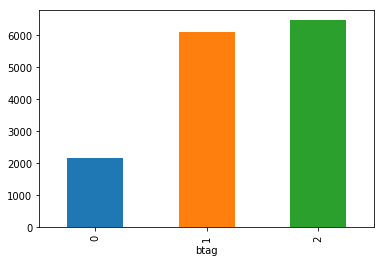

In [17]:
traindata.groupby('btag').count()['tweet'].plot(kind='bar')

We notice that there is a class imbalance for negative tweets. We will therefore use the macro-average for all the evaluation metrics. 

In [18]:
vocabulary

Counter({'iranian': 1,
         'general': 13,
         'says': 157,
         'iron': 5,
         'dome': 3,
         'deal': 64,
         'missiles': 1,
         'talking': 48,
         'like': 736,
         'may': 2017,
         'end': 120,
         'finding': 11,
         'davlar': 1,
         'main': 27,
         'rivals': 3,
         'team': 135,
         'hopefully': 47,
         'make': 411,
         'successful': 7,
         'tough': 22,
         'week': 105,
         'training': 27,
         'deciding': 5,
         'want': 399,
         'go': 546,
         'applying': 3,
         'colleges': 1,
         'everything': 40,
         'college': 46,
         'stresses': 1,
         'superbowl': 9,
         'dallas': 35,
         'winning': 43,
         'quarterback': 2,
         'im': 112,
         'bringing': 27,
         'monster': 5,
         'load': 4,
         'candy': 15,
         'hope': 218,
         'get': 731,
         'squiched': 1,
         'apple': 252,
         'retai

## Experimenting with Bag of Words
<a id="1-03"></a> 

In [19]:
len(vocabulary_with_neg)

23863

In [20]:
voc_with_neg = list(sorted(vocabulary_with_neg))

In [21]:
train_vec = np.zeros((len(traindata),len(vocabulary_with_neg) + 1))
bin_train_vec = np.zeros((len(traindata),len(vocabulary_with_neg) + 1))
test_vec = np.zeros((len(testdata),len(vocabulary_with_neg) + 1))
bin_test_vec = np.zeros((len(testdata),len(vocabulary_with_neg) + 1))

In [22]:
train_vec

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [23]:
test_vec.shape

(15596, 23864)

In [24]:
for i in list(traindata.index.values.astype(int)):
    for token in traindata.neg_tokens[i]:
        if token in voc_with_neg:
            j = voc_with_neg.index(token)
            train_vec[i,j]+=1
            bin_train_vec[i,j]==1
            
for i in list(testdata.index.values.astype(int)):
    for token in testdata.neg_tokens[i]:
        if token in voc_with_neg:
            j = voc_with_neg.index(token)
            test_vec[i,j]+=1
            bin_test_vec[i,j]==1
            

### Multinomial Naive Bayes classifier
<a id="1-03-01"></a> 

In [25]:
X_train = train_vec
Y_train = traindata['btag'].values
X_test = test_vec
Y_test = testdata['btag'].values

In [26]:
n_b = MultinomialNB()

In [27]:
n_b.fit(X = X_train,y = Y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [28]:
predicted = n_b.predict(X_test)
accuracy = n_b.score(X_test,Y_test)
precision= precision_score(Y_test, predicted, average='macro')
recall = recall_score(Y_test, predicted, average='macro')
f1 = f1_score(Y_test, predicted, average='macro')
print("Multinomial Naive Bayes: Accuracy: %0.2f Precision: %0.2f Recall: %0.2f F_1 score: %0.2f" 
          % (accuracy, precision, recall, f1))

Multinomial Naive Bayes: Accuracy: 0.55 Precision: 0.53 Recall: 0.49 F_1 score: 0.49


### Boolean Naive Bayes classifier
<a id="1-03-02"></a> 

In [29]:
b_n_b = MultinomialNB()

In [30]:
X_train = bin_train_vec
X_test = bin_test_vec

In [31]:
b_n_b.fit(X = X_train,y = Y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [32]:
predicted = b_n_b.predict(X_test)
accuracy = b_n_b.score(X_test,Y_test)
precision= precision_score(Y_test, predicted, average='macro')
recall = recall_score(Y_test, predicted, average='macro')
f1 = f1_score(Y_test, predicted, average='macro')
print("Boolean Naive Bayes: Accuracy: %0.2f Precision: %0.2f Recall: %0.2f F_1 score: %0.2f" 
          % (accuracy, precision, recall, f1))

Boolean Naive Bayes: Accuracy: 0.35 Precision: 0.12 Recall: 0.33 F_1 score: 0.17


### Principal Component Analysis
<a id="1-03-03"></a> 

In [33]:
X_train = train_vec
Y_train = traindata['btag'].values
X_test = test_vec
Y_test = testdata['btag'].values

In [34]:
scaler = StandardScaler().fit(X_train)
rescaledX_train = scaler.transform(X_train)
rescaledX_test = scaler.transform(X_test)

In [35]:
%%time
pca = PCA(copy = True)
fit = pca.fit(rescaledX_train)

Wall time: 27min 25s


In [36]:
%%time
plt.figure(figsize=(15,10))
plt.plot(np.cumsum(fit.explained_variance_ratio_), marker = 'D', markerfacecolor='red', markevery=100)
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance')
plt.yticks(np.arange(0.00,1.02,0.02))
plt.grid()
plt.show()

Wall time: 788 ms


In [37]:
exp = np.cumsum(fit.explained_variance_ratio_)
print( "The first %0.0f components explain 0.95 of the model's variance."    %(len(exp) - len(exp [exp>0.95])))

The first 9304 components explain 0.95 of the model's variance.


In [38]:
%%time
pca = PCA(n_components = (len(exp) - len(exp [exp>0.95])), copy = True)
fit = pca.fit(rescaledX_train)
#transform train data
X_train_red = fit.transform(rescaledX_train)
#transform test data
X_test_red = fit.transform(rescaledX_test)


Wall time: 22min 28s


### Testing Algorithms and Ensembles with PCA
<a id="1-03-04"></a> 

In [39]:
#we choose a common seed for all algorithms
seed = 2015
#we choose a common number of trees for ensembles
num_trees = 100

models = []
models.append(('Decision Tree',  DecisionTreeClassifier(criterion='entropy',max_depth=10,random_state = seed)))
models.append(('Logistic Regression',  LogisticRegression(random_state = seed)))
models.append(('kNN', neighbors.KNeighborsClassifier(n_neighbors = 3, weights='uniform', n_jobs=-1)))
models.append(('Random Forest', RandomForestClassifier(n_estimators=num_trees, max_depth=10,n_jobs=-1,random_state=seed)))
models.append(('Bagged Trees', BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',max_depth=10,random_state = seed), 
                                                 n_estimators=num_trees, random_state=seed, n_jobs=-1)))
models.append(('AdaBoost',AdaBoostClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('XGBoost',XGBClassifier(nthread=8)))

In [40]:
%%time
results = []
names   = []
for name, model in models:
    #fit the model
    model.fit(X_train_red,Y_train)
    predicted = model.predict(X_test_red)
    
    #gather metrics
    accuracy = model.score(X_test_red,Y_test)
    precision= precision_score(Y_test, predicted, average = 'macro')
    recall = recall_score(Y_test, predicted, average = 'macro')
    f1 = f1_score(Y_test, predicted, average = 'macro')
    sc_results = [accuracy,precision,recall,f1]
    results.append(sc_results)
    names.append(name)
    print("%03s: Accuracy: %0.2f Precision: %0.2f Recall: %0.2f F_1 score: %0.2f" 
          % (name, accuracy, precision, recall, f1))

Decision Tree: Accuracy: 0.43 Precision: 0.39 Recall: 0.38 F_1 score: 0.37
Logistic Regression: Accuracy: 0.50 Precision: 0.46 Recall: 0.46 F_1 score: 0.46
kNN: Accuracy: 0.40 Precision: 0.39 Recall: 0.36 F_1 score: 0.32
Random Forest: Accuracy: 0.46 Precision: 0.54 Recall: 0.38 F_1 score: 0.33
Bagged Trees: Accuracy: 0.47 Precision: 0.46 Recall: 0.38 F_1 score: 0.34
AdaBoost: Accuracy: 0.47 Precision: 0.43 Recall: 0.42 F_1 score: 0.41


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBoost: Accuracy: 0.50 Precision: 0.50 Recall: 0.41 F_1 score: 0.37
Wall time: 2h 41min 25s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [41]:
plt.figure(figsize=(15,10))
plt.boxplot(results)
plt.xticks(list(range(1,len(names)+1)), names)
plt.title('Algorithm scoring summary')
plt.show()

## Experimenting with embeddings
<a id="1-04"></a> 

We will now experiment with embeddings. We will load the 50 dimension version of the glove.twitter.27B pre-trained embeddings, using our train vocabulary, without the negation encoding (not_\*). In order to handle performance issues, limited computation resources and array size per tweet issues, we will sum the embeddings for all words in a tweet, ending up with a 50-dimension array for each tweet. 

We will then test all the algorithms that we used in the bag-of-words approach, excluding Naive Bayes, as it would require us to re-scale the embeddings to positive values. Given the fact that summing the embeddings is already a drastic skew on the data, we decided against that choice. 

### Loading the pre-trained embeddings
<a id="1-04-01"></a> 

In [42]:
# Load embeddings into a dict...
embeddings_index = {}
glove_data = 'glove.twitter.27B.50d.txt'
f = open(glove_data, encoding = 'utf-8')
for line in f:
    values = line.split()
    word = values[0]
    value = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = value
f.close()
 
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 1193514 word vectors.


In [43]:
#word_index = tokenizer.word_index
word_index = vocabulary

In [44]:
def get_embedding (tweet):
    embedding_dimension = 50
    embedding_matrix = np.zeros((len(tweet) + 1, embedding_dimension))
    i = 0
    for token in tweet:
        embedding_vector = embeddings_index.get(token)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector;#[:embedding_dimension]
            i+=1
    return embedding_matrix.sum(axis=0)

In [45]:
traindata['embeddings'] = [np.array(get_embedding(tweet)) for tweet in traindata.tokens]

In [46]:
testdata['embeddings'] = [np.array(get_embedding(tweet)) for tweet in testdata.tokens]
testdata['embeddings'] = np.array(testdata['embeddings'])

In [47]:
traindata

user_id sentiment  \
0      264249301910310912  negative   
1      264105751826538497  positive   
2      264094586689953794  negative   
3      254941790757601280  negative   
4      264169034155696130   neutral   
5      263192091700654080   neutral   
6      263398998675693568  positive   
7      260200142420992000   neutral   
8      264087629237202944  positive   
9      250692636330049538   neutral   
10     263304719471087617   neutral   
11     263956867787673600  positive   
12     263975113404342273   neutral   
13     257343699460173824  positive   
14     264125591337463808  negative   
15     264259830590603264  negative   
16     257239661976625152   neutral   
17     264223934403211264   neutral   
18     264041764460036096  positive   
19     264102295392882689  positive   
20     264071572925603841  positive   
21     262115068320284672  positive   
22     264239636799430656   neutral   
23     257951107530252289  negative   
24     236665189502681089   neutral   
25     262384414623936512   neutral   
26     249228128302551040   neutral   
27     263346444772184065  positive   
28     263970913270251520  positive   
29     264162997088436224  positive   
...                   ...       ...   
14686  631153745053679616  positive   
14687  631226630904651776  positive   
14688  631543249031819264  positive   
14689  631588786380664832  positive   
14690  631895213741621248  positive   
14691  632226904473530368  positive   
14692  632309720209080320   neutral   
14693  632326452667482112   neutral   
14694  632349185971392512  positive   
14695  632823882584588288  positive   
14696  634021249283420161  positive   
14697  634353168596340736   neutral   
14698  634355631940612097  positive   
14699  634372935541592065  positive   
14700  634412669727047681  positive   
14701  634800750833594368  positive   
14702  634902054562086912   neutral   
14703  635129647747989504   neutral   
14704  635460536445063168  positive   
14705  636324904258904065  positive   
14706  636714456546975744  positive   
14707  637342059519680513  negative   
14708  638533993344864256  positive   
14709  639295526995890177  positive   
14710  639804828739346432  positive   
14711  639855845958885376  positive   
14712  639979760735662080   neutral   
14713  640196838260363269   neutral   
14714  640975710354567168  positive   
14715  641034340068143104   neutral   

                                                                                                                                                  tweet  \
0                         Iranian general says Israel's Iron Dome can't deal with their missiles (keep talking like that and we may end up finding out)   
1                       with J Davlar 11th. Main rivals are team Poland. Hopefully we an make it a successful end to a tough week of training tomorrow.   
2      Talking about ACT's &amp;&amp; SAT's, deciding where I want to go to college, applying to colleges and everything about college stresses me out.   
3                 They may have a SuperBowl in Dallas, but Dallas ain't winning a SuperBowl. Not with that quarterback and owner. @S4NYC @RasmussenPoll   
4                                                               Im bringing the monster load of candy tomorrow, I just hope it doesn't get all squiched   
5              Apple software, retail chiefs out in overhaul: SAN FRANCISCO Apple Inc CEO Tim Cook on Monday replaced the heads... http://t.co/X49ZEOsG   
6                          @oluoch @victor_otti @kunjand I just watched it! Sridevi's comeback.... U remember her from the 90s?? Sun mornings on NTA ;)   
7              #Livewire Nadal confirmed for Mexican Open in February: Rafael Nadal is set to play at the Me... http://t.co/zgUXpcnC #LiveWireAthletics   
8          @MsSheLahY I didnt want to just pop up... but yep we have chapel hill next wednesday you should come.. and shes great ill tell her you asked   
9             @Alyoup005 @addicted2haley hmmmm  N

In [48]:
train_vec = np.array([traindata['embeddings'][i] for i in range(0,len(traindata))])

In [49]:
train_vec.shape

(14716, 50)

In [50]:
train_vec

array([[ 0.37202194,  4.60821673,  0.14038859, ...,  0.788965  ,
        -0.60080002,  4.19043991],
       [ 3.803342  ,  1.45029499, -0.820029  , ...,  1.343703  ,
         2.66241794,  2.55903261],
       [ 5.78679909,  2.42991904,  0.87116501, ...,  3.02342004,
        -1.756528  ,  1.02816801],
       ...,
       [ 6.02040997,  1.68973595,  0.33565461, ..., -4.21367091,
         1.70198396,  3.37619001],
       [ 0.78981806,  4.19326083, -0.350855  , ..., -2.84845402,
         0.30051999,  2.36027101],
       [-1.68141395,  2.64155999,  0.77204999, ..., -0.97745004,
        -0.17660998,  0.93959494]])

In [51]:
test_vec = np.array([testdata['embeddings'][i] for i in range(0,len(testdata))])

In [52]:
X_train = train_vec
Y_train = traindata['btag'].values
X_test = test_vec
Y_test = testdata['btag'].values

### Testing Algorithms and Ensembles with embeddings
<a id="1-04-02"></a> 

In [53]:
#we choose a common seed for all algorithms
seed = 2015
#we choose a common number of trees for ensembles
num_trees = 100

models = []
models.append(('Decision Tree',  DecisionTreeClassifier(criterion='entropy',max_depth=10,random_state = seed)))
models.append(('Logistic Regression',  LogisticRegression(random_state = seed)))
models.append(('kNN', neighbors.KNeighborsClassifier(n_neighbors = 3, weights='uniform', n_jobs=-1)))
models.append(('Random Forest', RandomForestClassifier(n_estimators=num_trees, max_depth=10,n_jobs=-1,random_state=seed)))
models.append(('Bagged Trees', BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',max_depth=10,random_state = seed), 
                                                 n_estimators=num_trees, random_state=seed, n_jobs=-1)))
models.append(('AdaBoost',AdaBoostClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('XGBoost',XGBClassifier(n_jobs=8)))
models.append(('SVM',SVC(cache_size=12288, kernel='linear')))

In [54]:
%%time
results = []
names   = []
for name, model in models:
    #fit the model
    model.fit(X_train,Y_train)
    predicted = model.predict(X_test)
    
    #gather metrics
    accuracy = model.score(X_test,Y_test)
    precision= precision_score(Y_test, predicted, average = 'macro')
    recall = recall_score(Y_test, predicted, average = 'macro')
    f1 = f1_score(Y_test, predicted, average = 'macro')
    sc_results = [accuracy,precision,recall,f1]
    results.append(sc_results)
    names.append(name)
    print("%03s: Accuracy: %0.2f Precision: %0.2f Recall: %0.2f F_1 score: %0.2f" 
          % (name, accuracy, precision, recall, f1))

Decision Tree: Accuracy: 0.50 Precision: 0.45 Recall: 0.44 F_1 score: 0.44
Logistic Regression: Accuracy: 0.58 Precision: 0.57 Recall: 0.53 F_1 score: 0.53
kNN: Accuracy: 0.45 Precision: 0.43 Recall: 0.45 F_1 score: 0.42
Random Forest: Accuracy: 0.56 Precision: 0.58 Recall: 0.47 F_1 score: 0.45
Bagged Trees: Accuracy: 0.56 Precision: 0.56 Recall: 0.49 F_1 score: 0.49
AdaBoost: Accuracy: 0.55 Precision: 0.52 Recall: 0.52 F_1 score: 0.51


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBoost: Accuracy: 0.57 Precision: 0.56 Recall: 0.51 F_1 score: 0.51
SVM: Accuracy: 0.57 Precision: 0.51 Recall: 0.46 F_1 score: 0.43
Wall time: 50min 36s


In [55]:
plt.figure(figsize=(15,10))
plt.boxplot(results)
plt.xticks(list(range(1,len(names)+1)), names)
plt.title('Algorithm scoring summary')
plt.show()

It is quite obvious that the embeddings approach vastly improves both the running time for each algorithm (as the vectors are much smaller) as well as the performance of all algorithms. 

We deem **logistic regression** as the most promising, given its high accuracy, precision and recall. 

## Hyper-Parameter Tuning

Given its best performance, we have chose logistic regression, with pre-trained embeddings as the most promising solution. We will now use a grid search cross validation approach to fine-tune all the available hyper-parameters of the model. 

In [56]:
from sklearn.metrics import classification_report, make_scorer
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

In [57]:
my_f1 = make_scorer(f1_score, greater_is_better=True, average='macro')

In [58]:
model = LogisticRegression(random_state =2015,n_jobs=-1,multi_class='ovr')

In [59]:
%%time
c = [0.001,0.01,0.1,1.0]
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
class_weights=['balanced',None]

grid = GridSearchCV(estimator=model, param_grid=dict(C=c, solver=solvers, class_weight=class_weights)
                    ,scoring='accuracy',
                    cv=5, refit='accuracy')
grid.fit(X_train, Y_train)

Wall time: 8min 56s


In [60]:
grid.best_score_

0.5553139440065236

In [61]:
grid.best_estimator_

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=2015, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [62]:
grid.best_params_

{'C': 0.01, 'class_weight': None, 'solver': 'liblinear'}

In [63]:
candidate_model = grid.best_estimator_

In [64]:
predicted = candidate_model.predict(X_test)
print(classification_report(Y_test,predicted, labels = [0,1,2],))
print('Accuracy: %0.2f'  % candidate_model.score(X_test,Y_test))

             precision    recall  f1-score   support

          0       0.54      0.29      0.38      2305
          1       0.65      0.55      0.60      7807
          2       0.53      0.74      0.62      5484

avg / total       0.59      0.58      0.57     15596

Accuracy: 0.58


# Testing a ready-to-use sentiment analysis application
<a id="2"></a> 

We will play around with the pattern.en.sentiment out-of-the-box sentiment analyzer. 

For more information please follow this link: https://www.clips.uantwerpen.be/pages/pattern-en#sentiment

In [65]:
from pattern.en import sentiment

As a first test we will feed the application with the raw tweets. Supposedly the algorithm does all the preprocessiong on its own. 

In [66]:
pattern_result = []
for tweet in testdata['tweet']:
    if round(sentiment(tweet)[0]) == -1:
        s = 0
    elif round(sentiment(tweet)[0]) == 0:
        s = 1
    elif round(sentiment(tweet)[0]) == 1:
        s = 2
    pattern_result.append(s)

In [67]:
testdata['pattern_result']= pattern_result

In [68]:
testdata

user_id sentiment  \
0      619969366986235905   neutral   
1      619974445185302528   neutral   
2      619987808317407232  positive   
3      619994586182619136  positive   
4      619998879447162881  positive   
5      619999109991284737   neutral   
6      620013074272137216  positive   
7      620015047889154048   neutral   
8      620015649151021056   neutral   
9      620017122081685504   neutral   
10     620023409901043712   neutral   
11     620024331322699776   neutral   
12     620027768131203072  positive   
13     620031929182621696   neutral   
14     620033827046596608   neutral   
15     620035146083880961   neutral   
16     620040573395701760   neutral   
17     620045069605691392   neutral   
18     620045849373093892  positive   
19     620045999977963520   neutral   
20     620056577341562884  positive   
21     620063502682599425  positive   
22     620068767930802177   neutral   
23     620073648255168512  positive   
24     620076360040583169   neutral   
25     620080951708651520  positive   
26     620084129640546304   neutral   
27     620099074679701509  negative   
28     620111581230149632   neutral   
29     620125231164715008  positive   
...                   ...       ...   
15566  681752164545368065   neutral   
15567  681755356108840960  positive   
15568  681756270299230208   neutral   
15569  681758580580708352  negative   
15570  681761278810025984  negative   
15571  681761397085044736   neutral   
15572  681766612035227648   neutral   
15573  681766788607115264   neutral   
15574  681774918598447104  negative   
15575  681778448726011906  positive   
15576  681790588354752512  negative   
15577  681791411826601985  positive   
15578  681802784627404800   neutral   
15579  681803218062569472   neutral   
15580  681815330839105536   neutral   
15581  681816181834121217  positive   
15582  681820172659757057   neutral   
15583  681820700592701440  positive   
15584  681827597962096641  positive   
15585  681833181545390083   neutral   
15586  681836125795794944   neutral   
15587  681874672590438401   neutral   
15588  681875112086261760   neutral   
15589  681875586063548416   neutral   
15590  681876093133930496   neutral   
15591  681877834982232064   neutral   
15592  681879579129200640  positive   
15593  681883903259357184   neutral   
15594  681904976860327936  negative   
15595  681910549211287552   neutral   

                                                                                                                                              tweet  \
0      Order Go Set a Watchman in store or through our website before Tuesday and get it half price! #GSAW @GSAWatchmanBook https://t.co/KET6EGD1an   
1                                                            If you could ask an onstage interview question at Miss USA tomorrow, what would it be?   
2      A portion of book sales from our Harper Lee/Go Set a Watchman release party on Mon. 7/13 will support @CAP_Tulsa and the great work they do.   
3                           Excited to read "Go Set a Watchman" on Tuesday.  But can it possibly live up to "To Kill a Mockingbird?"  Any opinions?   
4                                                        Watching Miss USA tomorrow JUST to see @TravisGarland perform, I'm obsessed with his voice   
5        Tune-in for the 2015 MISS USA Pageant on ReelzChannel on Sunday, July 12 at 8p ET/5p PT. Contestants from all 50... http://t.co/M3kJowOvQ1   
6           Call for reservations for lunch or dinner tomorrow (yep Sunday!). Happy to accommodate guests in town for the MISS USA Pageant 346-5100   
7       Miss Universe Org prez tells me #Trump won't attend Sunday's Miss USA event He's missed some in the past, but he said recently he'd be here   
8      Trump said June 30th that he'd be at Miss USA pageant in Baton Rouge. Organizers say he's not coming. No word yet from his camp on his plans   
9        Haven't read To Kill a Mockingbird in years. That may be a good thing for when I

In [69]:
correct = 0
for i in range(0,len(testdata)):
    if testdata['btag'][i]==testdata['pattern_result'][i]:
        correct+=1

In [70]:
accuracy = correct/len(testdata)

In [71]:
print('Accuracy: %0.2f' % accuracy)

Accuracy: 0.54


As we can see the accuracy of the pre-trained algorithm is worse than our fine-tuned model.

We also run the algorithm with the clean vectorised tokens.

In [72]:
pattern_result = []
for tweet in testdata['vector_tokens']:
    if round(sentiment(tweet)[0]) == -1:
        s = 0
    elif round(sentiment(tweet)[0]) == 0:
        s = 1
    elif round(sentiment(tweet)[0]) == 1:
        s = 2
    pattern_result.append(s)

In [73]:
testdata['pattern_result']= pattern_result

In [74]:
testdata

user_id sentiment  \
0      619969366986235905   neutral   
1      619974445185302528   neutral   
2      619987808317407232  positive   
3      619994586182619136  positive   
4      619998879447162881  positive   
5      619999109991284737   neutral   
6      620013074272137216  positive   
7      620015047889154048   neutral   
8      620015649151021056   neutral   
9      620017122081685504   neutral   
10     620023409901043712   neutral   
11     620024331322699776   neutral   
12     620027768131203072  positive   
13     620031929182621696   neutral   
14     620033827046596608   neutral   
15     620035146083880961   neutral   
16     620040573395701760   neutral   
17     620045069605691392   neutral   
18     620045849373093892  positive   
19     620045999977963520   neutral   
20     620056577341562884  positive   
21     620063502682599425  positive   
22     620068767930802177   neutral   
23     620073648255168512  positive   
24     620076360040583169   neutral   
25     620080951708651520  positive   
26     620084129640546304   neutral   
27     620099074679701509  negative   
28     620111581230149632   neutral   
29     620125231164715008  positive   
...                   ...       ...   
15566  681752164545368065   neutral   
15567  681755356108840960  positive   
15568  681756270299230208   neutral   
15569  681758580580708352  negative   
15570  681761278810025984  negative   
15571  681761397085044736   neutral   
15572  681766612035227648   neutral   
15573  681766788607115264   neutral   
15574  681774918598447104  negative   
15575  681778448726011906  positive   
15576  681790588354752512  negative   
15577  681791411826601985  positive   
15578  681802784627404800   neutral   
15579  681803218062569472   neutral   
15580  681815330839105536   neutral   
15581  681816181834121217  positive   
15582  681820172659757057   neutral   
15583  681820700592701440  positive   
15584  681827597962096641  positive   
15585  681833181545390083   neutral   
15586  681836125795794944   neutral   
15587  681874672590438401   neutral   
15588  681875112086261760   neutral   
15589  681875586063548416   neutral   
15590  681876093133930496   neutral   
15591  681877834982232064   neutral   
15592  681879579129200640  positive   
15593  681883903259357184   neutral   
15594  681904976860327936  negative   
15595  681910549211287552   neutral   

                                                                                                                                              tweet  \
0      Order Go Set a Watchman in store or through our website before Tuesday and get it half price! #GSAW @GSAWatchmanBook https://t.co/KET6EGD1an   
1                                                            If you could ask an onstage interview question at Miss USA tomorrow, what would it be?   
2      A portion of book sales from our Harper Lee/Go Set a Watchman release party on Mon. 7/13 will support @CAP_Tulsa and the great work they do.   
3                           Excited to read "Go Set a Watchman" on Tuesday.  But can it possibly live up to "To Kill a Mockingbird?"  Any opinions?   
4                                                        Watching Miss USA tomorrow JUST to see @TravisGarland perform, I'm obsessed with his voice   
5        Tune-in for the 2015 MISS USA Pageant on ReelzChannel on Sunday, July 12 at 8p ET/5p PT. Contestants from all 50... http://t.co/M3kJowOvQ1   
6           Call for reservations for lunch or dinner tomorrow (yep Sunday!). Happy to accommodate guests in town for the MISS USA Pageant 346-5100   
7       Miss Universe Org prez tells me #Trump won't attend Sunday's Miss USA event He's missed some in the past, but he said recently he'd be here   
8      Trump said June 30th that he'd be at Miss USA pageant in Baton Rouge. Organizers say he's not coming. No word yet from his camp on his plans   
9        Haven't read To Kill a Mockingbird in years. That may be a good thing for when I

In [75]:
correct = 0
for i in range(0,len(testdata)):
    if testdata['btag'][i]==testdata['pattern_result'][i]:
        correct+=1

In [76]:
accuracy = correct/len(testdata)

In [77]:
print('Accuracy: %0.2f' % accuracy)

Accuracy: 0.54


As expected, pre-processing doesn't change the behavior of the pre-trained model. 